In [1]:
pip install wandb -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43853")

# Import

In [3]:
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,Callback
import inspect
import itertools
import matplotlib.colors as mcolors
import glob, os
from random import randrange

In [4]:
import myParam3Ddata
import myTorchModels3D

In [5]:
import importlib

In [6]:
importlib.reload(myParam3Ddata)

<module 'myParam3Ddata' from '/home/jovyan/oceanDataNotebooks/density_ML/myParam3Ddata.py'>

In [7]:
import platform
print(platform.platform())

Linux-5.10.133+-x86_64-with-glibc2.35


In [8]:
print(torch.__version__)

1.13.1.post200


In [9]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

# Useful functions

In [10]:
line_styles = ['solid', 'dashed', 'dotted', 'dashdot']

# Prepare data

In [11]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET'] 

In [12]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA'})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO'})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

In [13]:
features_to_add_to_sample = ['votemper', 'votemper_var', 'rho_ct_ct', 'diff_votemper_sqr']

In [14]:
batch_size = 4

In [15]:
%%time
all_data = myParam3Ddata.PyLiDataModule(data_dict, features_to_add_to_sample, batch_size=batch_size)

CPU times: user 14.9 s, sys: 4.13 s, total: 19 s
Wall time: 1min 29s


# Run routine

In [16]:
def run_experiment(config, project) :
    wandb_logger = WandbLogger(name=config['model_label']+'_'+config['version'], \
                               version=config['model_label']+'_'+config['version'],\
                               project=project, config=config, resume=True, log_model=True)
    
    torch_model = eval(config['torch_model'])(**config['torch_model_params'])
    pylight_module = myParam3Ddata.GenericPyLiModule(torch_model, **config['module_params'])
    
    # Callbacks
    checkpoint_callback = ModelCheckpoint(monitor="loss_val", save_last=True)    
    early_stopping_callback = EarlyStopping(monitor="loss_val", mode="min")
    
    trainer = pl.Trainer(**config['training_params'], logger=wandb_logger, 
                     callbacks=[early_stopping_callback, checkpoint_callback],
                     accelerator='gpu', devices=(1 if torch.cuda.is_available() else None))  
    trainer.fit(model = pylight_module, datamodule=eval(config['datamodule']))
    #tests
    test_datamodule = eval(config['datamodule'])
    test_datamodule.setup(stage='test')
    trainer.test(model = pylight_module, datamodule=test_datamodule)
    wandb.finish()

# List of configs

In [17]:
list_of_configs = list()

## Linear regression

In [18]:
list_of_configs.append(dict({'model_label' : 'LinReg',
                'version' : 'valueLoss',
                'torch_model' : 'myTorchModels3D.lin_regr_model',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1}),
                'module_params' : dict({'input_features'  : ['diff_votemper_sqr'],
                                        'output_features'  : ['votemper_var'],
                                        'loss' : torch.nn.functional.huber_loss,
                                        'optimizer' : torch.optim.SGD,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

In [19]:
list_of_configs.append(dict({'model_label' : 'LinReg',
                'version' : 'gradLoss',
                'torch_model' : 'myTorchModels3D.lin_regr_model',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1}),
                'module_params' : dict({'input_features'  : ['diff_votemper_sqr'],
                                        'output_features'  : ['votemper_var'],
                                        'loss' : myParam3Ddata.gradient_based_MSEloss,
                                        'optimizer' : torch.optim.SGD,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 100,
                                          'limit_train_batches' : 1.0})
               }))

## FCNN on patches

In [20]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in3_out1',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 3,
                                            'output_patch_size' : 1, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['normalized_votemper'],
                                        'output_features'  : ['normalized_votemper_var'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 50,
                                          'limit_train_batches' : 1.0})
               }))

In [21]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in3_out3',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 3,
                                            'output_patch_size' : 3, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['normalized_votemper'],
                                        'output_features'  : ['normalized_votemper_var'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 50,
                                          'limit_train_batches' : 1.0})
               }))

In [22]:
list_of_configs.append(dict({'model_label' : 'FCNN',
                'version' : 'patch_in5_out3',
                'torch_model' : 'myTorchModels3D.FCNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                            'input_patch_size' : 5,
                                            'output_patch_size' : 3, 
                                            'int_layer_width' : 50}),
                'module_params' : dict({'input_features'  : ['normalized_votemper'],
                                        'output_features'  : ['normalized_votemper_var'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 50,
                                          'limit_train_batches' : 1.0})
               }))

## CNN

In [23]:
list_of_configs.append(dict({'model_label' : 'CNN',
                'version' : 'kernel3',
                'torch_model' : 'myTorchModels3D.CNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                             'kernel_size' : 3, \
                                            'int_layer_width' : 64}),
                'module_params' : dict({'input_features'  : ['normalized_votemper'],
                                        'output_features'  : ['normalized_votemper_var'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 50,
                                          'limit_train_batches' : 1.0})
               }))

In [24]:
list_of_configs.append(dict({'model_label' : 'CNN',
                'version' : 'kernel5',
                'torch_model' : 'myTorchModels3D.CNN',
                'datamodule' : 'all_data',
                'torch_model_params' : dict({'nb_of_input_features' : 1, \
                                            'nb_of_output_features' : 1, \
                                             'kernel_size' : 5, \
                                            'int_layer_width' : 64}),
                'module_params' : dict({'input_features'  : ['normalized_votemper'],
                                        'output_features'  : ['normalized_votemper_var'],
                                        'loss' : torch.nn.functional.mse_loss,
                                        'optimizer' : torch.optim.Adam,
                                        'learning_rate' : 1e-3,}),
                'training_params' : dict({'max_epochs' : 50,
                                          'limit_train_batches' : 1.0})
               }))

# Runs

In [25]:
len(list_of_configs)

7

In [26]:
project_name = 'SGS_temp_var_param_3Ddata'

In [27]:
wandb.finish()

In [28]:
for config in list_of_configs :
    run_experiment(config, project_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anagorb63. Use `wandb login --relogin` to force relogin


/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params
-----------------------------------------------
0 | torch_model | lin_regr_model | 1     
-----------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃        DataLoader 0        ┃       DataLoader 1        ┃        DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_votemper_… │     0.6990363001823425     │    0.6940482258796692     │     0.6482169032096863     │
│  corr_coef_votemper_var   │     0.7958097457885742     │    0.7883106470108032     │     0.8395931124687195     │
│  loss_grad_votemper_var   │     1.1390641927719116     │    0.5200655460357666     │    0.37039709091186523     │
│   loss_val_votemper_var   │    0.07964003831148148     │    0.04653244838118553    │    0.018072018399834633    │
└───────────────────────────┴────────────────────────────┴───────────────────────────┴────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃        DataLoader 3        ┃       DataLoader 4        ┃        DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_votemper_… │     0.7831475138664246     │    0.5086966156959534     │     0.5103299021720886     │
│  corr_coef_votemper_var   │     0.8579818606376648     │    0.7896432280540466     │     0.7639347314834595     │
│  loss_grad_votemper_var   │     0.3609839379787445     │  2.3367768164916924e-07   │   0.0001398290041834116    │
│   loss_val_votemper_var   │    0.011992191895842552    │   6.136959564173594e-05   │   0.0008129708585329354    │
└───────────────────────────┴────────────────────────────┴───────────────────────────┴────────────────────────────┘

corr_coef_grad_votemper_var/dataloader_idx_0,▁
corr_coef_grad_votemper_var/dataloader_idx_1,▁
corr_coef_grad_votemper_var/dataloader_idx_2,▁
corr_coef_grad_votemper_var/dataloader_idx_3,▁
corr_coef_grad_votemper_var/dataloader_idx_4,▁
corr_coef_grad_votemper_var/dataloader_idx_5,▁
corr_coef_votemper_var/dataloader_idx_0,▁
corr_coef_votemper_var/dataloader_idx_1,▁
corr_coef_votemper_var/dataloader_idx_2,▁
corr_coef_votemper_var/dataloader_idx_3,▁
corr_coef_votemper_var/dataloader_idx_4,▁


/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type           | Params
-----------------------------------------------
0 | torch_model | lin_regr_model | 1     
-----------------------------------------------
1         Trainable params
0         Non-trainable params
1         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃        DataLoader 0        ┃       DataLoader 1        ┃        DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_votemper_… │     0.6990042924880981     │    0.6940931081771851     │     0.6481986045837402     │
│  corr_coef_votemper_var   │     0.7958101630210876     │    0.7883113026618958     │     0.8395923376083374     │
│  loss_grad_votemper_var   │     0.7835612893104553     │    0.3227608799934387     │     0.3013748824596405     │
│   loss_val_votemper_var   │    0.09591890871524811     │   0.059287477284669876    │    0.022262191399931908    │
└───────────────────────────┴────────────────────────────┴───────────────────────────┴────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃        DataLoader 3        ┃       DataLoader 4        ┃        DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_votemper_… │     0.7831206321716309     │    0.5086833238601685     │     0.5103287696838379     │
│  corr_coef_votemper_var   │     0.8579763174057007     │    0.7896384000778198     │     0.7639448046684265     │
│  loss_grad_votemper_var   │    0.22066287696361542     │    1.8074582897043e-07    │   0.00010033627040684223   │
│   loss_val_votemper_var   │    0.01801212504506111     │   7.343345350818709e-05   │   0.0008906258153729141    │
└───────────────────────────┴────────────────────────────┴───────────────────────────┴────────────────────────────┘

corr_coef_grad_votemper_var/dataloader_idx_0,▁
corr_coef_grad_votemper_var/dataloader_idx_1,▁
corr_coef_grad_votemper_var/dataloader_idx_2,▁
corr_coef_grad_votemper_var/dataloader_idx_3,▁
corr_coef_grad_votemper_var/dataloader_idx_4,▁
corr_coef_grad_votemper_var/dataloader_idx_5,▁
corr_coef_votemper_var/dataloader_idx_0,▁
corr_coef_votemper_var/dataloader_idx_1,▁
corr_coef_votemper_var/dataloader_idx_2,▁
corr_coef_votemper_var/dataloader_idx_3,▁
corr_coef_votemper_var/dataloader_idx_4,▁


/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | FCNN | 3.1 K 
-------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃            DataLoader 1             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.6327655911445618          │         0.6155927777290344          │
│     corr_coef_grad_votemper_var     │         0.7004969716072083          │          0.686454176902771          │
│  corr_coef_normalized_votemper_var  │         0.7567810416221619          │         0.7641305327415466          │
│       corr_coef_votemper_var        │         0.7504745721817017          │         0.7768155932426453          │
│  loss_grad_normalized_votemper_var  │          7.285345077514648          │          9.369719505310059          │
│       loss_grad_votemper_var        │         0.6603913903236389          │         0.25929349660873413         │
│  loss_val_normalized_votemper_var   │         0.17458228766918182         │         0.1539217084646225          │
│        loss_val_votemper_var        │        0.052714407444000244         │        0.024616705253720284         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 2             ┃            DataLoader 3             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.5336472392082214          │          0.735358715057373          │
│     corr_coef_grad_votemper_var     │         0.5281999111175537          │         0.8125439286231995          │
│  corr_coef_normalized_votemper_var  │         0.7300851941108704          │         0.7846596240997314          │
│       corr_coef_votemper_var        │         0.7033473253250122          │         0.7825168967247009          │
│  loss_grad_normalized_votemper_var  │          54.50162124633789          │          7.864492416381836          │
│       loss_grad_votemper_var        │         0.4087519943714142          │         0.26531729102134705         │
│  loss_val_normalized_votemper_var   │         0.5120876431465149          │          0.190067857503891          │
│        loss_val_votemper_var        │        0.031648147851228714         │         0.01921369507908821         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 4             ┃            DataLoader 5             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.41847431659698486         │         0.35609376430511475         │
│     corr_coef_grad_votemper_var     │         0.3448624014854431          │         0.35653552412986755         │
│  corr_coef_normalized_votemper_var  │         0.5296341776847839          │         0.5091440081596375          │
│       corr_coef_votemper_var        │         0.6023687720298767          │         0.5913998484611511          │
│  loss_grad_normalized_votemper_var  │          4.938987731933594          │          3.642207145690918          │
│       loss_grad_votemper_var        │        2.505736063085351e-07        │       0.00011557346442714334        │
│  loss_val_normalized_votemper_var   │         0.3330177366733551          │         0.29624971747398376         │
│        loss_val_votemper_var        │        7.752944657113403e-05        │        0.0008670611423440278        │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

corr_coef_grad_normalized_votemper_var/dataloader_idx_0,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_1,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_2,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_3,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_4,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_5,▁
corr_coef_grad_votemper_var/dataloader_idx_0,▁
corr_coef_grad_votemper_var/dataloader_idx_1,▁
corr_coef_grad_votemper_var/dataloader_idx_2,▁
corr_coef_grad_votemper_var/dataloader_idx_3,▁
corr_coef_grad_votemper_var/dataloader_idx_4,▁


/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | FCNN | 3.5 K 
-------------------------------------
3.5 K     Trainable params
0         Non-trainable params
3.5 K     Total params
0.014     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃            DataLoader 1             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.6231529712677002          │         0.6167671084403992          │
│     corr_coef_grad_votemper_var     │         0.7280322313308716          │         0.6866805553436279          │
│  corr_coef_normalized_votemper_var  │         0.7433488368988037          │         0.7487386465072632          │
│       corr_coef_votemper_var        │         0.7334772348403931          │          0.756754994392395          │
│  loss_grad_normalized_votemper_var  │         7.9154815673828125          │          10.79485034942627          │
│       loss_grad_votemper_var        │         0.5787838697433472          │         0.30847305059432983         │
│  loss_val_normalized_votemper_var   │         0.18374031782150269         │         0.1670144498348236          │
│        loss_val_votemper_var        │         0.05385930836200714         │        0.026480749249458313         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 2             ┃            DataLoader 3             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.4789004921913147          │         0.6792609691619873          │
│     corr_coef_grad_votemper_var     │         0.46992793679237366         │         0.7306420207023621          │
│  corr_coef_normalized_votemper_var  │          0.556096076965332          │         0.5850145220756531          │
│       corr_coef_votemper_var        │         0.5437726974487305          │         0.5847545266151428          │
│  loss_grad_normalized_votemper_var  │          51.39202117919922          │          6.449055194854736          │
│       loss_grad_votemper_var        │         0.3895682394504547          │         0.20208267867565155         │
│  loss_val_normalized_votemper_var   │         0.5053462982177734          │         0.17987217009067535         │
│        loss_val_votemper_var        │         0.03176778554916382         │        0.018086440861225128         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 4             ┃            DataLoader 5             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.3871970474720001          │         0.3520154058933258          │
│     corr_coef_grad_votemper_var     │         0.35703057050704956         │         0.34130150079727173         │
│  corr_coef_normalized_votemper_var  │         0.4878021776676178          │         0.4790610373020172          │
│       corr_coef_votemper_var        │         0.5791259407997131          │          0.573085606098175          │
│  loss_grad_normalized_votemper_var  │          8.363733291625977          │         3.5081145763397217          │
│       loss_grad_votemper_var        │        2.504746987597173e-07        │       0.00011530810297699645        │
│  loss_val_normalized_votemper_var   │         0.3525356352329254          │         0.2945106327533722          │
│        loss_val_votemper_var        │        7.724075112491846e-05        │        0.0008840705850161612        │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

corr_coef_grad_normalized_votemper_var/dataloader_idx_0,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_1,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_2,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_3,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_4,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_5,▁
corr_coef_grad_votemper_var/dataloader_idx_0,▁
corr_coef_grad_votemper_var/dataloader_idx_1,▁
corr_coef_grad_votemper_var/dataloader_idx_2,▁
corr_coef_grad_votemper_var/dataloader_idx_3,▁
corr_coef_grad_votemper_var/dataloader_idx_4,▁


/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | FCNN | 4.3 K 
-------------------------------------
4.3 K     Trainable params
0         Non-trainable params
4.3 K     Total params
0.017     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃            DataLoader 1             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.6697700619697571          │          0.625004768371582          │
│     corr_coef_grad_votemper_var     │         0.7324029207229614          │         0.6784714460372925          │
│  corr_coef_normalized_votemper_var  │          0.790854275226593          │         0.7857419848442078          │
│       corr_coef_votemper_var        │         0.7736592292785645          │         0.7866177558898926          │
│  loss_grad_normalized_votemper_var  │          7.171763896942139          │         11.866948127746582          │
│       loss_grad_votemper_var        │         0.5376884937286377          │         0.3279833197593689          │
│  loss_val_normalized_votemper_var   │         0.16505298018455505         │         0.1781255453824997          │
│        loss_val_votemper_var        │         0.05012695491313934         │        0.028926944360136986         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 2             ┃            DataLoader 3             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.5077968835830688          │         0.7311518788337708          │
│     corr_coef_grad_votemper_var     │         0.48853662610054016         │         0.8012356162071228          │
│  corr_coef_normalized_votemper_var  │         0.6619302034378052          │          0.747687816619873          │
│       corr_coef_votemper_var        │         0.6236812472343445          │         0.7308135628700256          │
│  loss_grad_normalized_votemper_var  │          52.91584777832031          │          7.53041410446167           │
│       loss_grad_votemper_var        │         0.4003858268260956          │         0.24042247235774994         │
│  loss_val_normalized_votemper_var   │         0.5351032018661499          │         0.1733827441930771          │
│        loss_val_votemper_var        │         0.03326345980167389         │         0.01710856333374977         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 4             ┃            DataLoader 5             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.43872952461242676         │         0.49486401677131653         │
│     corr_coef_grad_votemper_var     │         0.3857076168060303          │         0.4114903211593628          │
│  corr_coef_normalized_votemper_var  │         0.5585904717445374          │         0.5813668370246887          │
│       corr_coef_votemper_var        │         0.6264155507087708          │         0.6122283935546875          │
│  loss_grad_normalized_votemper_var  │          5.371006488800049          │         3.4217560291290283          │
│       loss_grad_votemper_var        │         2.5352582611049e-07         │       0.00011983527656411752        │
│  loss_val_normalized_votemper_var   │         0.36381280422210693         │         0.30088090896606445         │
│        loss_val_votemper_var        │        7.940189971122891e-05        │        0.0009372664499096572        │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

corr_coef_grad_normalized_votemper_var/dataloader_idx_0,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_1,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_2,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_3,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_4,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_5,▁
corr_coef_grad_votemper_var/dataloader_idx_0,▁
corr_coef_grad_votemper_var/dataloader_idx_1,▁
corr_coef_grad_votemper_var/dataloader_idx_2,▁
corr_coef_grad_votemper_var/dataloader_idx_3,▁
corr_coef_grad_votemper_var/dataloader_idx_4,▁


/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | CNN  | 38.1 K
-------------------------------------
38.1 K    Trainable params
0         Non-trainable params
38.1 K    Total params
0.153     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃            DataLoader 1             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.6923497319221497          │          0.655360996723175          │
│     corr_coef_grad_votemper_var     │         0.7693564891815186          │         0.7280835509300232          │
│  corr_coef_normalized_votemper_var  │          0.782905101776123          │         0.7867751717567444          │
│       corr_coef_votemper_var        │         0.7763811945915222          │         0.7983234524726868          │
│  loss_grad_normalized_votemper_var  │          5.644786357879639          │         7.8118696212768555          │
│       loss_grad_votemper_var        │         0.4610177278518677          │         0.2132178395986557          │
│  loss_val_normalized_votemper_var   │         0.11811143904924393         │         0.11413207650184631         │
│        loss_val_votemper_var        │        0.037339191883802414         │        0.019541656598448753         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 2             ┃            DataLoader 3             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.6166187524795532          │         0.7699769735336304          │
│     corr_coef_grad_votemper_var     │         0.6158249974250793          │         0.8555395007133484          │
│  corr_coef_normalized_votemper_var  │          0.788972795009613          │         0.8263227343559265          │
│       corr_coef_votemper_var        │         0.7881398797035217          │         0.8373262286186218          │
│  loss_grad_normalized_votemper_var  │         42.981773376464844          │          5.694633483886719          │
│       loss_grad_votemper_var        │         0.3170519471168518          │         0.14379407465457916         │
│  loss_val_normalized_votemper_var   │         0.40002989768981934         │         0.14987383782863617         │
│        loss_val_votemper_var        │        0.022815220057964325         │        0.014759276993572712         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 4             ┃            DataLoader 5             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.4468800127506256          │         0.4256768524646759          │
│     corr_coef_grad_votemper_var     │         0.3759109675884247          │         0.3526822328567505          │
│  corr_coef_normalized_votemper_var  │         0.5134101510047913          │         0.5213309526443481          │
│       corr_coef_votemper_var        │         0.5986220240592957          │         0.5958912372589111          │
│  loss_grad_normalized_votemper_var  │          5.769671440124512          │          3.062213897705078          │
│       loss_grad_votemper_var        │        2.443536288865289e-07        │       0.00011183175956830382        │
│  loss_val_normalized_votemper_var   │         0.30328670144081116         │         0.25792357325553894         │
│        loss_val_votemper_var        │        7.163600821513683e-05        │        0.0008731106063351035        │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

corr_coef_grad_normalized_votemper_var/dataloader_idx_0,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_1,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_2,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_3,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_4,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_5,▁
corr_coef_grad_votemper_var/dataloader_idx_0,▁
corr_coef_grad_votemper_var/dataloader_idx_1,▁
corr_coef_grad_votemper_var/dataloader_idx_2,▁
corr_coef_grad_votemper_var/dataloader_idx_3,▁
corr_coef_grad_votemper_var/dataloader_idx_4,▁


/srv/conda/envs/notebook/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type | Params
-------------------------------------
0 | torch_model | CNN  | 105 K 
-------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.423     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃            DataLoader 1             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.7643941044807434          │         0.7408180236816406          │
│     corr_coef_grad_votemper_var     │          0.803428590297699          │          0.782723069190979          │
│  corr_coef_normalized_votemper_var  │         0.8250827193260193          │         0.8412026166915894          │
│       corr_coef_votemper_var        │         0.7982493042945862          │         0.8448551297187805          │
│  loss_grad_normalized_votemper_var  │          4.224274635314941          │          6.426895618438721          │
│       loss_grad_votemper_var        │         0.42828625440597534         │         0.18801578879356384         │
│  loss_val_normalized_votemper_var   │         0.0946958065032959          │         0.09794436395168304         │
│        loss_val_votemper_var        │        0.034201428294181824         │        0.017091967165470123         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 2             ┃            DataLoader 3             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.6393619775772095          │         0.7948415279388428          │
│     corr_coef_grad_votemper_var     │         0.6429035067558289          │         0.8656876087188721          │
│  corr_coef_normalized_votemper_var  │          0.789394199848175          │         0.8295526504516602          │
│       corr_coef_votemper_var        │         0.7873271703720093          │          0.821051299571991          │
│  loss_grad_normalized_votemper_var  │          42.24320602416992          │          6.364951133728027          │
│       loss_grad_votemper_var        │         0.3065597712993622          │         0.17268718779087067         │
│  loss_val_normalized_votemper_var   │         0.3978276550769806          │         0.13807204365730286         │
│        loss_val_votemper_var        │        0.022644581273198128         │        0.013277367688715458         │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 4             ┃            DataLoader 5             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ corr_coef_grad_normalized_votemper… │         0.42529386281967163         │         0.4235425293445587          │
│     corr_coef_grad_votemper_var     │         0.3872433304786682          │         0.3867316246032715          │
│  corr_coef_normalized_votemper_var  │         0.5068148970603943          │         0.5278393030166626          │
│       corr_coef_votemper_var        │         0.6108283400535583          │         0.6031705141067505          │
│  loss_grad_normalized_votemper_var  │          5.651576519012451          │         2.8453941345214844          │
│       loss_grad_votemper_var        │       2.2849826564197429e-07        │        9.828908514464274e-05        │
│  loss_val_normalized_votemper_var   │         0.3277377486228943          │         0.26441076397895813         │
│        loss_val_votemper_var        │        6.803813448641449e-05        │        0.0008798956987448037        │
└─────────────────────────────────────┴─────────────────────────────────────┴─────────────────────────────────────┘

corr_coef_grad_normalized_votemper_var/dataloader_idx_0,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_1,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_2,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_3,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_4,▁
corr_coef_grad_normalized_votemper_var/dataloader_idx_5,▁
corr_coef_grad_votemper_var/dataloader_idx_0,▁
corr_coef_grad_votemper_var/dataloader_idx_1,▁
corr_coef_grad_votemper_var/dataloader_idx_2,▁
corr_coef_grad_votemper_var/dataloader_idx_3,▁
corr_coef_grad_votemper_var/dataloader_idx_4,▁


# Load checkpoints

In [29]:
api = wandb.Api()

In [30]:
list_of_models = [dict() for i in range(len(list_of_configs))]

In [31]:
for i, config in enumerate(list_of_configs) : 
    checkpoint_reference = 'anagorb63/'+project_name+"/model-"+config['model_label']+'_'+config['version']+':v0'
    artifact = api.artifact(checkpoint_reference)
    artifact_dir = artifact.download()
    list_of_models[i]['best'] = myParam3Ddata.GenericPyLiModule.load_from_checkpoint(os.path.abspath(artifact_dir)+"/model.ckpt")
    list_of_models[i]['label'] = config['model_label']+'_'+config['version']
    list_of_models[i]['model_name'] = config['model_label']
    list_of_models[i]['version'] = config['version']

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


# Get truth and predictions

In [32]:
%%time
test_datamodule = all_data
test_datamodule.setup(stage='test')

CPU times: user 0 ns, sys: 337 µs, total: 337 µs
Wall time: 93 µs


In [33]:
%%time
for i, model in enumerate(list_of_models) :
    trainer = pl.Trainer(accelerator='gpu', devices=1)
    model['pred'] = dict()
    prediction_dict = trainer.predict(model['best'], dataloaders=test_datamodule.test_dataloader())
    for feature in list(prediction_dict[0][0].keys()) :
        model['pred'][feature] = [prediction_dict[idx_dataset][0][feature] for idx_dataset in range(len(test_datamodule.test_dataloader()))]
    del prediction_dict

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

CPU times: user 33.2 s, sys: 2.83 s, total: 36 s
Wall time: 10.3 s


Ground truth:

In [34]:
truth = dict()
for feature in ['votemper_var', 'rho_ct_ct', 'f'] :
    truth[feature] = [torch.Tensor() for i in range(len(test_datamodule.test_dataloader()))]

In [35]:
for i, dataloader in enumerate(test_datamodule.test_dataloader()) :
    iterator = iter(dataloader)
    sample = next(iterator)
    for feature in ['votemper_var', 'rho_ct_ct'] :
        truth[feature][i] = sample[feature].where(sample['mask'][:,None,:,:], torch.ones_like(sample['mask'][:,None,:,:])*np.nan)

# Retrieve metrics

In [36]:
metrics_list = ['loss_val', 'loss_grad', 'corr_coef', 'corr_coef_grad']

In [37]:
feature_list = ['votemper_var']

In [41]:
for i, model in enumerate(list_of_models) : 
    run_id = model['label']
    run = api.run("anagorb63/"+project_name+"/"+run_id)
    metrics_table = run.history().iloc[-1]
    for feature in feature_list :
        model[feature] = dict()
        for metrics in metrics_list :
            model[feature][metrics] = [metrics_table[metrics+'_'+feature+'/dataloader_idx_'+str(idx)] for idx in range(len(test_datamodule.test_dataloader()))]

# Image examples

In [42]:
def plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, feature) : 
    fig, axs = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(2*(len(list_of_models)+1),5),sharex=True, sharey=True)
    fig.suptitle('Snapshots in ' + data_dict[idx_region]['label'])

    # clear subplots
    for ax in axs:
        ax.remove()

    # add subfigure per subplot
    gridspec = axs[0].get_subplotspec().get_gridspec()
    subfigs = [fig.add_subfigure(gs) for gs in gridspec]

    for row, subfig in enumerate(subfigs):
        axs = subfig.subplots(ncols=len(list_of_models)+1, nrows=1, sharex=True, sharey=True)
        img = axs[0].imshow(truth[feature][idx_region][idx_batch,idx_levels[row],:,:], \
                            cmap=('ocean_r' if (row==0) else current_cmap), \
                            #vmin=(None if (row==0) else color_min), vmax=(None if (row==0) else color_max), \
                            origin='lower')
        fig.colorbar(img, location='left',  shrink=0.8)
        axs[0].set(title='Truth')
        #if (row == 0) :
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
        current_cmap = img.cmap
        current_cmap.set_bad(color='silver')

        for i, model in enumerate(list_of_models) :
            img = axs[i+1].imshow(model['pred'][feature + '_masked'][idx_region][idx_batch,idx_levels[row],:,:], cmap=current_cmap, \
                                           vmin=color_min, vmax=color_max, origin='lower')
            axs[i+1].set(title=model['label'])
        fig.colorbar(img, ax=axs[-1], shrink=0.8)
    subfigs[0].suptitle('On the surface')
    subfigs[1].suptitle('At depth')
    plt.show()

In [43]:
idx_batch = 0

In [44]:
idx_levels = [0,106]

## Region 1 : Gulfstream (FMA)

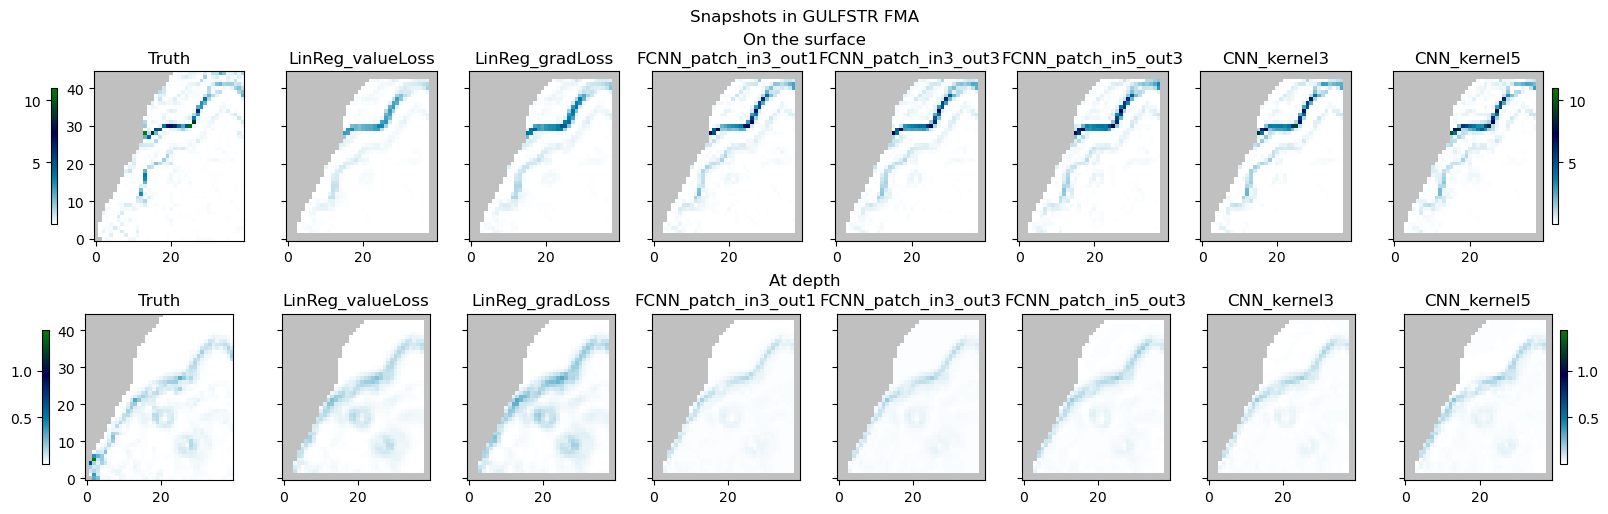

In [45]:
idx_region = 0

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

## Region 2 - Mid Atlantic (ASO)

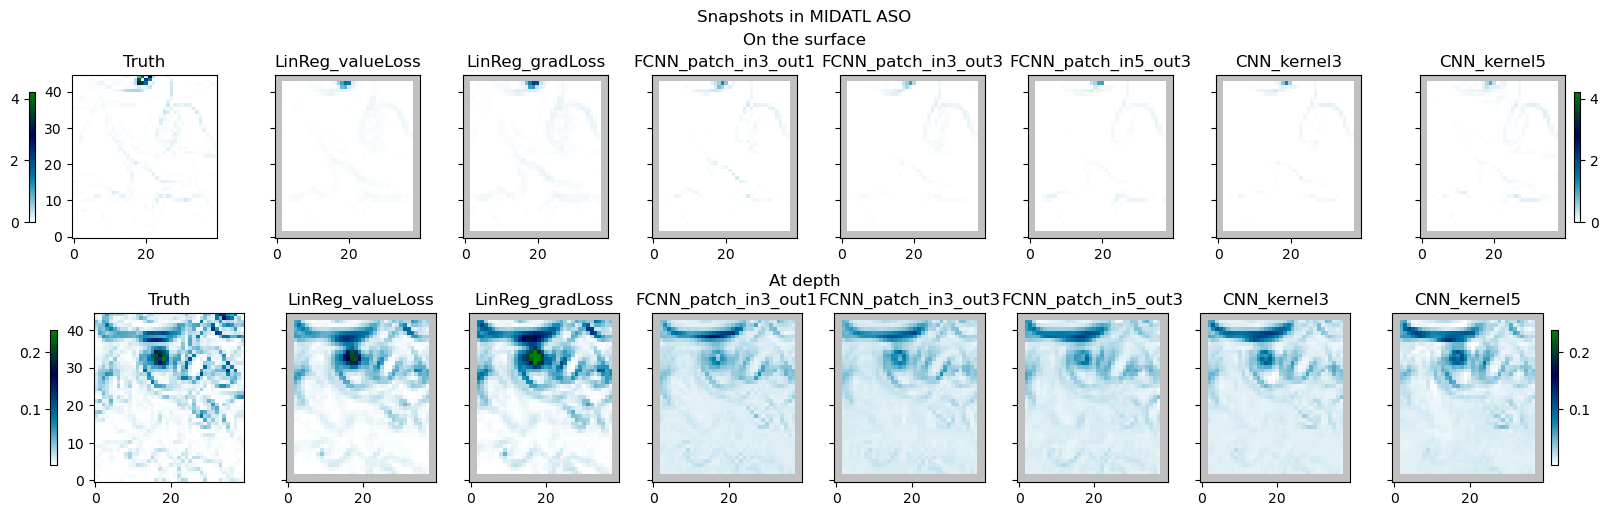

In [46]:
idx_region = 3

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

## Region 3 - WEDMED (ASO)

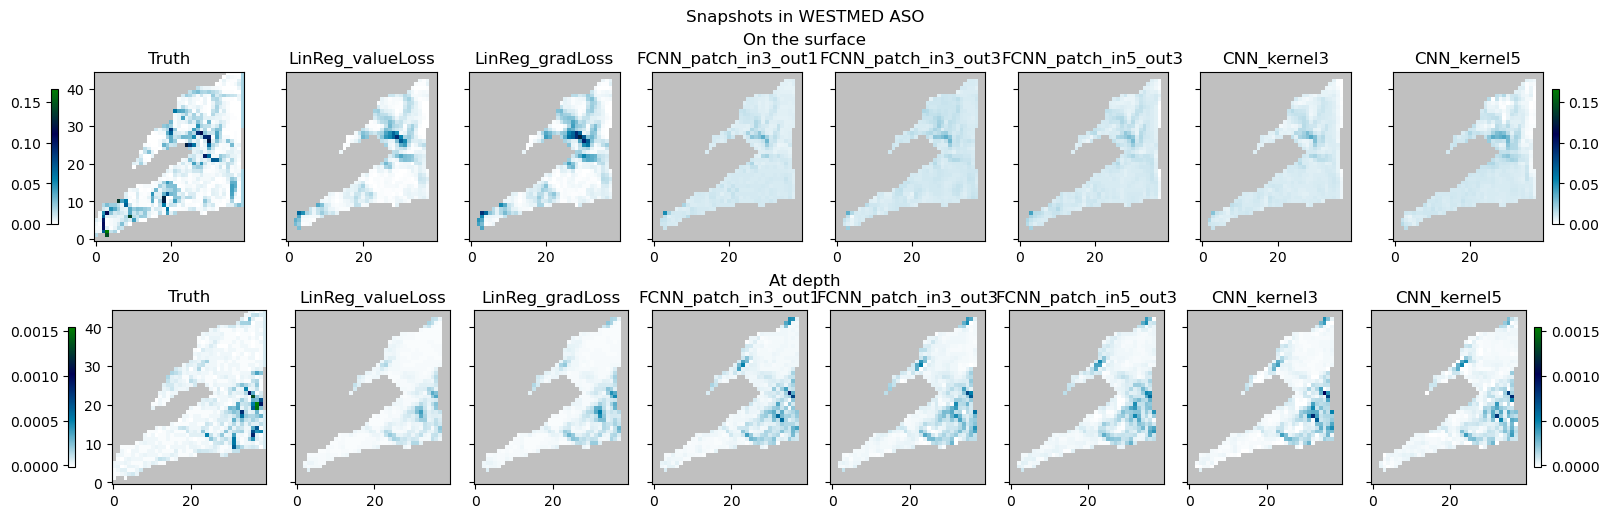

In [47]:
idx_region = 5

plot_snapshots_at_2depths(idx_batch, idx_levels, idx_region, 'votemper_var')

# Metrics over all datasets

In [48]:
bar_colors = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.BASE_COLORS.values())

In [49]:
xlabels = ['LinReg', 'FCNN', 'CNN']

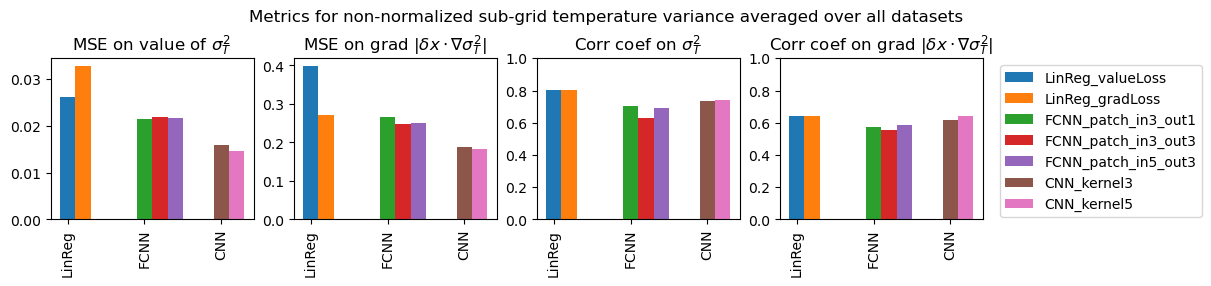

In [50]:
fig, ax = plt.subplots(1, len(metrics_list), constrained_layout=True, figsize=(3.0*len(metrics_list), 2.75), sharex=True)
fig.suptitle('Metrics for non-normalized sub-grid temperature variance averaged over all datasets')
x = np.arange(3)
versions = [0 for i in x]
bar_width = 0.2
feature = 'votemper_var'
for idx_model, model in enumerate(list_of_models) :
    i = xlabels.index(model['model_name'])
    j = versions[i]
    for idx, metrics in enumerate(metrics_list) :
        ax[idx].bar(x[i]+j*bar_width, np.mean(model[feature][metrics]), width=bar_width, label=model['label'])
        ax[idx].set_xticks(x, xlabels, rotation='vertical') 
    versions[i]+=1
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
for axis in ax[2::] :
    axis.set(ylim=[0,1])

ax[0].set(title=r'MSE on value of $\sigma_T^2$')
ax[1].set(title=r'MSE on grad $|\delta x \cdot \nabla \sigma_T^2|$')
ax[2].set(title=r'Corr coef on $\sigma_T^2$')
ax[3].set(title=r'Corr coef on grad $|\delta x \cdot \nabla \sigma_T^2|$')
plt.show()

## MSE across datasets (by region/season)

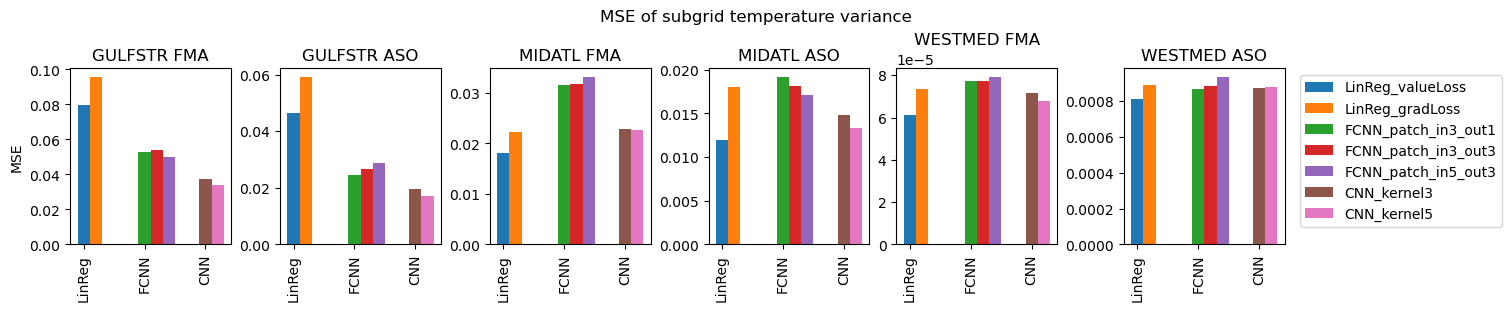

In [51]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0), sharex=True, sharey=False)
fig.suptitle('MSE of subgrid temperature variance')

feature = 'votemper_var'
metrics = 'loss_val'
for region in range(len(data_dict)) :
    versions = [0 for i in x]
    for idx_model, model in enumerate(list_of_models) :
        i = xlabels.index(model['model_name'])
        j = versions[i]
        ax[region].bar(x[i]+j*bar_width, model[feature][metrics][region], width=bar_width, label=model['label'])
        versions[i]+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Vertical profiles

In [52]:
nb_of_random_points = 6

In [53]:
random_points = [dict() for i in range(nb_of_random_points)]

In [54]:
i = 0
while (i < nb_of_random_points) : 
    x = randrange(2,sample['votemper_var'].shape[3]-9)
    y = randrange(2,sample['votemper_var'].shape[2]-9)
    if (sample['eroded_mask'][0,x,y] > 0) :
        random_points[i] = dict({'x': x, 'y': y})
        i+=1
    else :
        continue

In [55]:
random_points

[{'x': 9, 'y': 16},
 {'x': 21, 'y': 27},
 {'x': 16, 'y': 31},
 {'x': 5, 'y': 7},
 {'x': 12, 'y': 11},
 {'x': 11, 'y': 24}]

In [56]:
idx_region = 0
idx_batch = 0

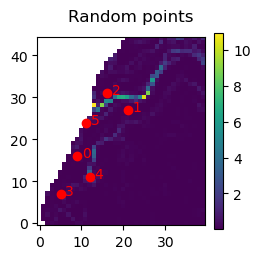

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(2.5,2.5),sharex=True, sharey=True)
fig.suptitle('Random points')
img = axs.imshow(truth['votemper_var'][idx_region][idx_batch,0,:,:], origin='lower')
xs=[point['x'] for point in random_points]
ys=[point['y'] for point in random_points]
for i, point in enumerate(random_points) : 
    axs.annotate(str(i), xy=(point['x'], point['y']), color='red', xytext=(3.5, -1), textcoords="offset points",)
axs.scatter(xs,ys, color='red')
fig.colorbar(img)
plt.show()

## Subgrid temp variance

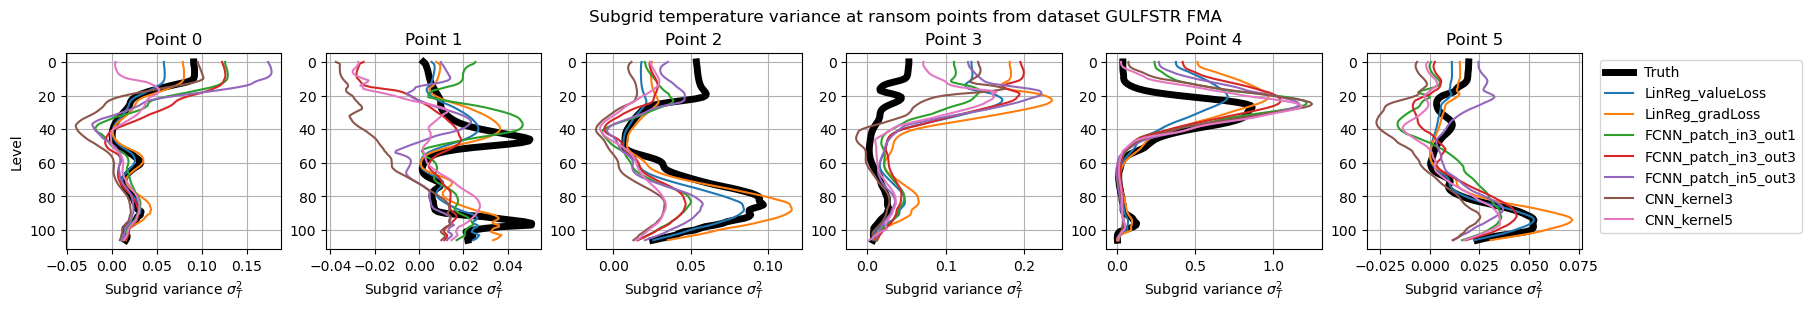

In [58]:
fig, ax = plt.subplots(1, len(random_points), constrained_layout=True, figsize=(3*len(random_points), 3), sharex=False,sharey=False)
y_vals = np.arange(truth['votemper_var'][idx_region].shape[1])
fig.suptitle('Subgrid temperature variance at ransom points from dataset '+data_dict[idx_region]['label'])

for idx, point in enumerate(random_points):
    x = point['x']
    y = point['y']
    x_vals = truth['votemper_var'][idx_region][idx_batch,:,x,y]
    ax[idx].plot(x_vals, y_vals, label='Truth', lw=5, color='k')
    for i, model in enumerate(list_of_models) :
        x_vals = model['pred']['votemper_var_masked'][idx_region][idx_batch,:,x,y]
        ax[idx].plot(x_vals, y_vals, label=model['label'], color=bar_colors[i])
    ax[idx].invert_yaxis() 
    ax[idx].set(xlabel=r'Subgrid variance $\sigma_T^2$', title='Point '+str(idx))
    ax[idx].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

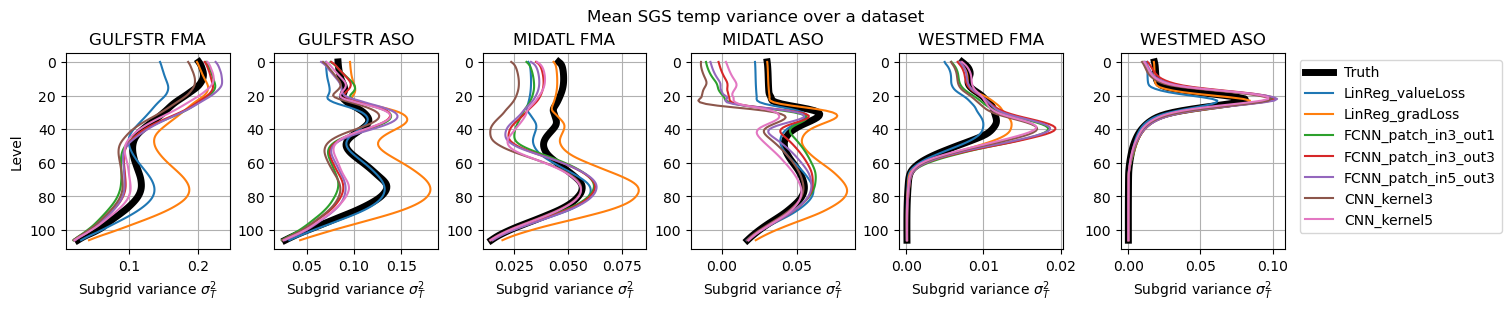

In [59]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
y_vals = np.arange(truth['votemper_var'][idx_region].shape[1])
fig.suptitle('Mean SGS temp variance over a dataset')

for idx_region in range(len(data_dict)) :
    ax[idx_region].plot(np.nanmean(truth['votemper_var'][idx_region], axis=(0,2,3)), y_vals, label='Truth', lw=5, color='k')
    line_counter=1
    for i, model in enumerate(list_of_models) :
        x_vals = np.nanmean(model['pred']['votemper_var_masked'][idx_region][:,:,:], axis=(0,2,3))
        ax[idx_region].plot(x_vals, y_vals, label=model['label'], ls='-', color=bar_colors[i])
    ax[idx_region].invert_yaxis() 
    ax[idx_region].set(title=data_dict[idx_region]['label'],xlabel=r'Subgrid variance $\sigma_T^2$')
    ax[idx_region].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Profiles of MSE

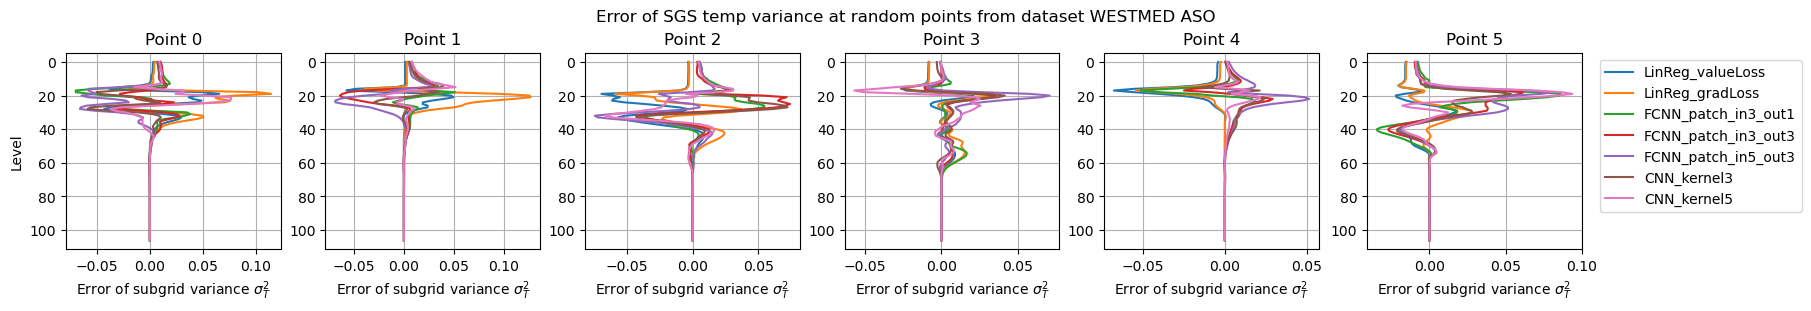

In [60]:
fig, ax = plt.subplots(1, len(random_points), constrained_layout=True, figsize=(3*len(random_points), 3), sharex=False,sharey=False)
y_vals = np.arange(truth['votemper_var'][idx_region].shape[1])
fig.suptitle('Error of SGS temp variance at random points from dataset '+data_dict[idx_region]['label'])

for idx, point in enumerate(random_points):
    x = point['x']
    y = point['y']
    line_counter = 1
    for i, model in enumerate(list_of_models) :
        x_vals = model['pred']['votemper_var_masked'][idx_region][idx_batch,:,x,y]-truth['votemper_var'][idx_region][idx_batch,:,x,y]
        ax[idx].plot(x_vals, y_vals, label=model['label'], color=bar_colors[i])
    ax[idx].invert_yaxis() 
    ax[idx].set(xlabel=r'Error of subgrid variance $\sigma_T^2$', title='Point '+str(idx))
    ax[idx].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

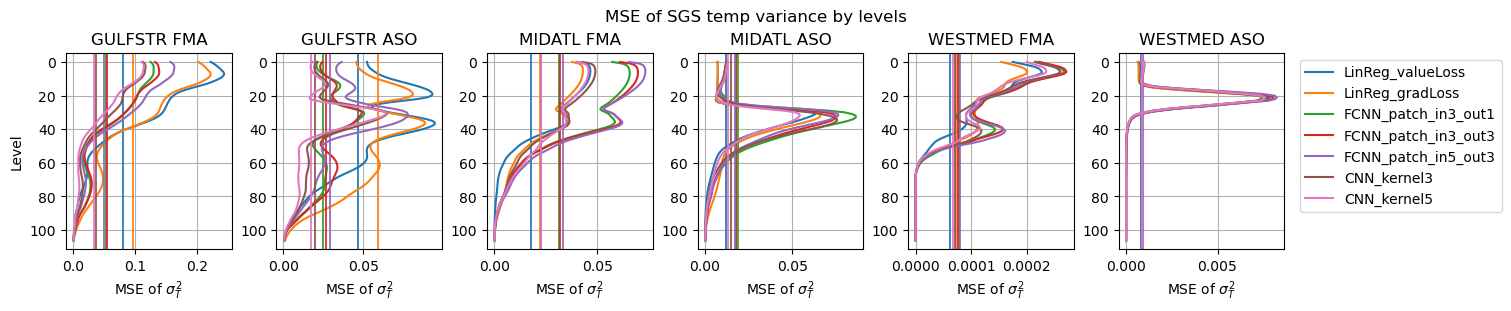

In [61]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
y_vals = np.arange(truth['votemper_var'][idx_region].shape[1])
fig.suptitle('MSE of SGS temp variance by levels')

for idx_region in range(len(data_dict)) :
    line_counter=0
    for i, model in enumerate(list_of_models) :
        x_vals = np.nanmean((model['pred']['votemper_var_masked'][idx_region]-\
                             truth['votemper_var'][idx_region])**2, axis=(0,2,3))
        ax[idx_region].plot(x_vals, y_vals, label=model['label'], ls='-', color=bar_colors[i])
        ax[idx_region].axvline(model['votemper_var']['loss_val'][idx_region], color=bar_colors[i], ls='-', lw=1.25)
    ax[idx_region].invert_yaxis() 
    ax[idx_region].set(title=data_dict[idx_region]['label'],xlabel=r'MSE of $\sigma_T^2$')
    ax[idx_region].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Pressure

In [62]:
g = 9.81

In [63]:
levels = test_datamodule.list_of_xr_datasets[0]['z_l']

In [64]:
dz = np.diff(levels)

In [65]:
def get_pressure_grad(votemper_var, rho_ct_ct) :
    rho = votemper_var*rho_ct_ct
    dx_rho = myParam3Ddata.central_diffs(rho, dim=3)[:,:-1,:,:]
    dy_rho = myParam3Ddata.central_diffs(rho, dim=2)[:,:-1,:,:]
    dx_p = np.nancumsum(dx_rho*g*dz[None,:,None,None], axis=1)   
    dy_p = np.nancumsum(dx_rho*g*dz[None,:,None,None], axis=1)
    return [dx_p, dy_p, np.sqrt(dx_p**2+dy_p**2)]

In [66]:
[truth['pressure_grad_x'], truth['pressure_grad_y'], truth['pressure_grad_norm']] = [[np.empty(shape=1) for i in range(len(data_dict))] for j in range(3)]

for idx_region in range(len(data_dict)) :
    [truth['pressure_grad_x'][idx_region], truth['pressure_grad_y'][idx_region], truth['pressure_grad_norm'][idx_region]] = \
    get_pressure_grad(truth['votemper_var'][idx_region], truth['rho_ct_ct'][idx_region])

In [67]:
for i, model in enumerate(list_of_models) :
    pred = model['pred']
    [pred['pressure_grad_x'], pred['pressure_grad_y'], pred['pressure_grad_norm'], pred['pressure_grad_error']] \
        = [[torch.Tensor() for i in range(len(data_dict))] for j in range(4)]
    for idx_region in range(len(data_dict)) :
        [pred['pressure_grad_x'][idx_region], pred['pressure_grad_y'][idx_region], pred['pressure_grad_norm'][idx_region]] \
        = get_pressure_grad(pred['votemper_var_masked'][idx_region], truth['rho_ct_ct'][idx_region])
        pred['pressure_grad_error'][idx_region] = np.sqrt((pred['pressure_grad_x'][idx_region]-truth['pressure_grad_x'][idx_region])**2+\
                                                          (pred['pressure_grad_y'][idx_region]-truth['pressure_grad_y'][idx_region])**2)

## Vertical profiles

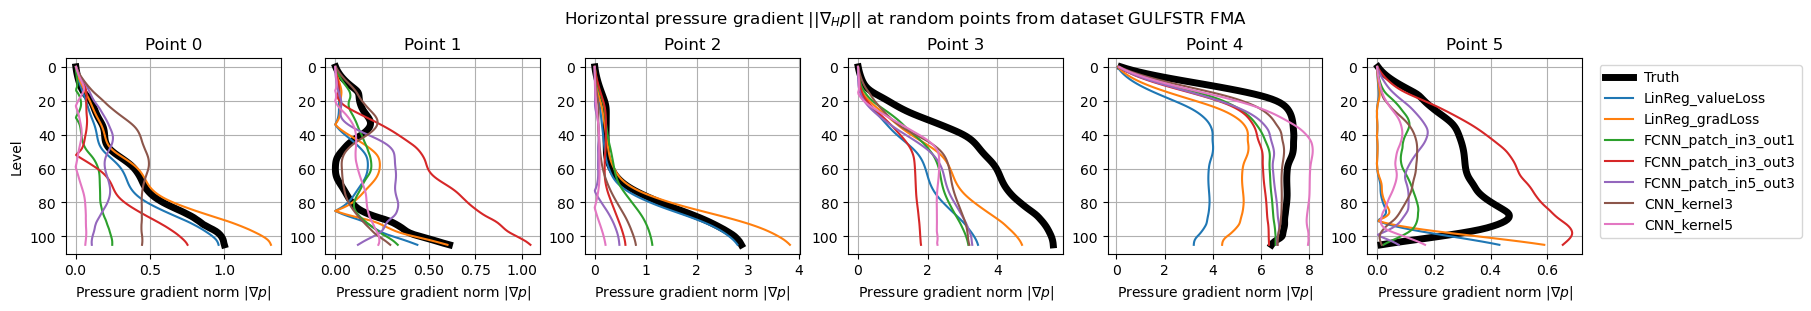

In [68]:
idx_region = 0
idx_batch = 0

fig, ax = plt.subplots(1, len(random_points), constrained_layout=True, figsize=(3*len(random_points), 3), sharex=False,sharey=False)
y_vals = np.arange(truth['pressure_grad_x'][0].shape[1])
fig.suptitle(r'Horizontal pressure gradient $||\nabla_H p||$ at random points from dataset '+data_dict[idx_region]['label'])

for idx, point in enumerate(random_points):
    x = point['x']
    y = point['y']
    x_vals = truth['pressure_grad_norm'][idx_region][idx_batch,:,x,y]
    ax[idx].plot(x_vals, y_vals, label='Truth', lw=5, color='k')
    for i, model in enumerate(list_of_models) :
        x_vals = model['pred']['pressure_grad_norm'][idx_region][idx_batch,:,x,y]
        ax[idx].plot(x_vals, y_vals, label=model['label'], color=bar_colors[i])
    ax[idx].invert_yaxis() 
    ax[idx].set(xlabel=r'Pressure gradient norm $|\nabla p|$', title='Point '+str(idx))
    ax[idx].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

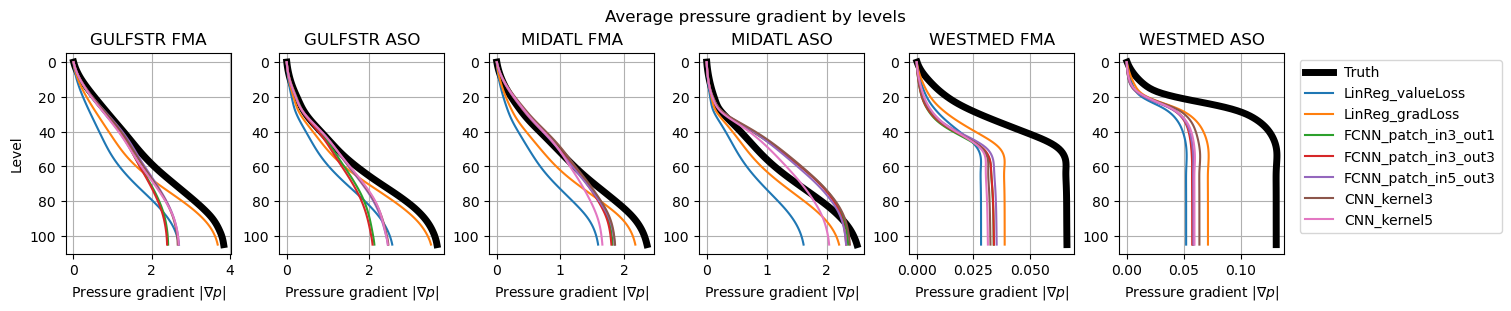

In [69]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
y_vals = np.arange(truth['pressure_grad_x'][0].shape[1])
fig.suptitle('Average pressure gradient by levels')

for idx_region in range(len(data_dict)) :
    ax[idx_region].plot(np.nanmean(truth['pressure_grad_norm'][idx_region], axis=(0,2,3)), y_vals, label='Truth', lw=5, color='k')
    for i, model in enumerate(list_of_models) :
        x_vals = np.nanmean(model['pred']['pressure_grad_norm'][idx_region][:,:,:], axis=(0,2,3))
        ax[idx_region].plot(x_vals, y_vals, label=model['label'], ls='-', color=bar_colors[i])
    ax[idx_region].invert_yaxis() 
    ax[idx_region].set(title=data_dict[idx_region]['label'],xlabel=r'Pressure gradient $|\nabla p|$')
    ax[idx_region].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## MSE

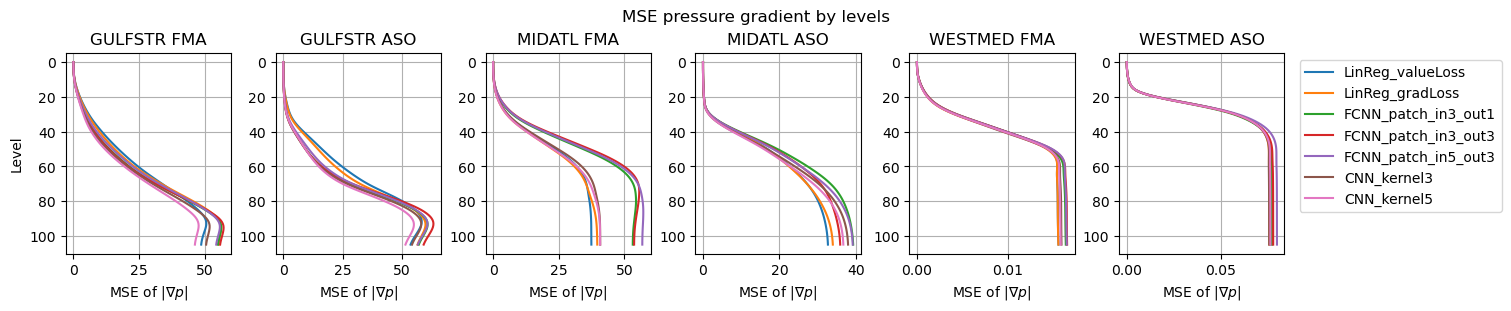

In [70]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
y_vals = np.arange(truth['pressure_grad_x'][0].shape[1])
fig.suptitle('MSE pressure gradient by levels')

for idx_region in range(len(data_dict)) :
    line_counter=1
    for i, model in enumerate(list_of_models) :
        x_vals = np.nanmean(model['pred']['pressure_grad_error'][idx_region][:,:,:]**2, axis=(0,2,3))
        ax[idx_region].plot(x_vals, y_vals, label=model['label'], ls='-', color=bar_colors[i])
    ax[idx_region].invert_yaxis() 
    ax[idx_region].set(title=data_dict[idx_region]['label'],xlabel=r'MSE of $|\nabla p|$')
    ax[idx_region].grid(True)
ax[0].set(ylabel='Level')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

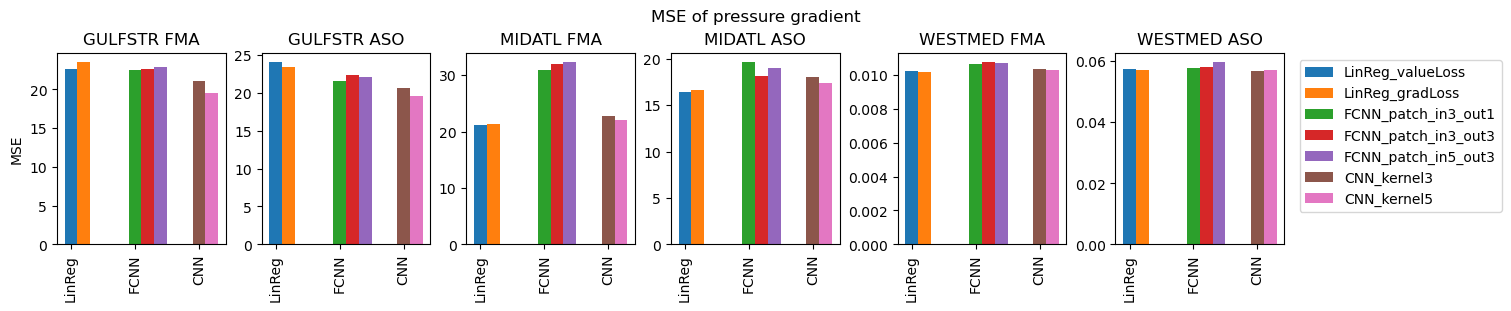

In [72]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3.0), sharex=True, sharey=False)
fig.suptitle('MSE of pressure gradient')
bar_width = 0.2
x = np.arange(3)
for region in range(len(data_dict)) :
    versions = [0 for i in x]
    for idx_model, model in enumerate(list_of_models) :
        i = xlabels.index(model['model_name'])
        j = versions[i]        
        bar_value = np.nanmean(model['pred']['pressure_grad_error'][region]**2)
        ax[region].bar(x[i]+j*bar_width, bar_value, width=bar_width, label=model['label'])
        versions[i]+=1
    ax[region].set_xticks(x, xlabels, rotation='vertical')
    ax[region].set(title=data_dict[region]['label'])
ax[0].set(ylabel='MSE')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()